In [3]:
# Comparing RO to INS data

import sys
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts")
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts/config")
from figs import plot
import motion

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os
from numpy import *

import module
import settings

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.titlepad'] = 20
plt.rcParams.update({'font.size': 16}) # was 28
plt.rcParams['axes.grid'] = True
plt.rcParams['text.usetex'] = True
# text
plt.rc("font", family=settings.FONT_FAMILY)

module.set_sys_paths()

from mrg.logging import MonolithicDecoder
from mrg.adaptors.transform import PbSerialisedTransformToPython
from mrg.transform.conversions import se3_to_components, build_se3_transform

import numpy as np
from config.data import *

colour_ro = u'#d62728' #red
colour_spline = u'#1f77b4' #blue
colour_kfc = u'#ff7f0e' #orange
colour_ero = u'#2ca02c' #green
colour_ins = 'black' #black

In [4]:
# dataset_path = "/Users/roberto/data/spline-experiments/10k-maple-plotting/"

# RO_relative_poses_path = dataset_path+"no-spline/ro_relative_poses.monolithic"
# spline_relative_poses_path = dataset_path+"with-spline/ro_relative_poses.monolithic"

dataset_path = "/tmp/"

RO_relative_poses_path = dataset_path+"ro_relative_poses.monolithic"
spline_relative_poses_path = dataset_path+"ro_spline_relative_poses.monolithic"

INS_relative_poses_path = dataset_path+"flattened_novatel_generated_poses.monolithic"

# INS - open monolithic and iterate frames
print("reading INS_relative_poses_path: " + INS_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    INS_relative_poses_path)

# iterate mono
INS_se3s = []
INS_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    INS_se3s.append(serialised_transform[0])
    INS_timestamps.append(serialised_transform[1])
    
# RO - open monolithic and iterate frames
print("reading RO_relative_poses_path: " + RO_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    RO_relative_poses_path)

# iterate mono
RO_se3s = []
RO_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    RO_se3s.append(serialised_transform[0])
    RO_timestamps.append(serialised_transform[1])
    
# Splined RO - open monolithic and iterate frames
print("reading spline_relative_poses_path: " + spline_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    spline_relative_poses_path)

# iterate mono
spline_se3s = []
spline_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    spline_se3s.append(serialised_transform[0])
    spline_timestamps.append(serialised_transform[1])
    
print("\nFinished importing.")

RO_se3s = RO_se3s[2:]
RO_timestamps = RO_timestamps[2:]
print("Cropped first two estimates from RO for easier data analysis.")

reading INS_relative_poses_path: /tmp/flattened_novatel_generated_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
reading RO_relative_poses_path: /tmp/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
reading spline_relative_poses_path: /tmp/ro_spline_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2

Finished importing.
Cropped first two estimates from RO for easier data analysis.


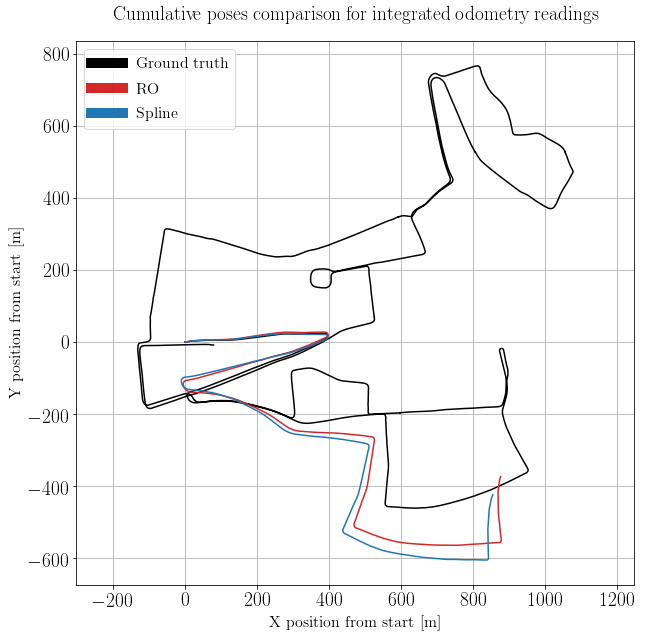

In [6]:
# get INS poses
INS_poses = []
pose = np.identity(4)
for i in range(len(INS_se3s)):
    pose = pose * INS_se3s[i]
    INS_poses.append(pose)

# get x,y coords
x_INS = [pose[0, 3] for pose in INS_poses]
y_INS = [pose[1, 3] for pose in INS_poses]
# downsample INS for figure rendering
x_INS_lite = x_INS[::10]
y_INS_lite = y_INS[::10]

# get RO poses
RO_poses = []
pose = np.identity(4)
for i in range(len(RO_se3s)):
    pose = pose * RO_se3s[i]
    RO_poses.append(pose)

# get x,y coords
x_RO = [pose[0, 3] for pose in RO_poses]
y_RO = [pose[1, 3] for pose in RO_poses]

# get spline poses
spline_poses = []
pose = np.identity(4)
for i in range(len(spline_se3s)):
    pose = pose * spline_se3s[i]
    spline_poses.append(pose)

# get x,y coords
x_spline = [pose[0, 3] for pose in spline_poses]
y_spline = [pose[1, 3] for pose in spline_poses]

plt.figure(figsize=(10,10)) # was 15,15
plt.plot(x_INS_lite,y_INS_lite,'-',color=colour_ins,markersize=1);
plt.plot(x_RO,y_RO,'-',color=colour_ro,markersize=1);
plt.plot(x_spline,y_spline,'-',color=colour_spline,markersize=1);
plt.axis('equal');
plt.title('Cumulative poses comparison for integrated odometry readings');
plt.xlabel('X position from start [m]');
plt.ylabel('Y position from start [m]');
line1, = plt.plot([],[],color=colour_ins,label='Ground truth',linewidth=10.0)
line2, = plt.plot([],[],color=colour_ro,label='RO',linewidth=10.0)
line3, = plt.plot([],[],color=colour_spline,label='Spline',linewidth=10.0)
# plt.xlim(150, 200)
# plt.ylim(0,20)

plt.legend(handles=[line1,line2,line3],loc='best')
plt.savefig(dataset_path+"figs/filename_all_poses.pdf",bbox_inches='tight',pad_inches = 0)

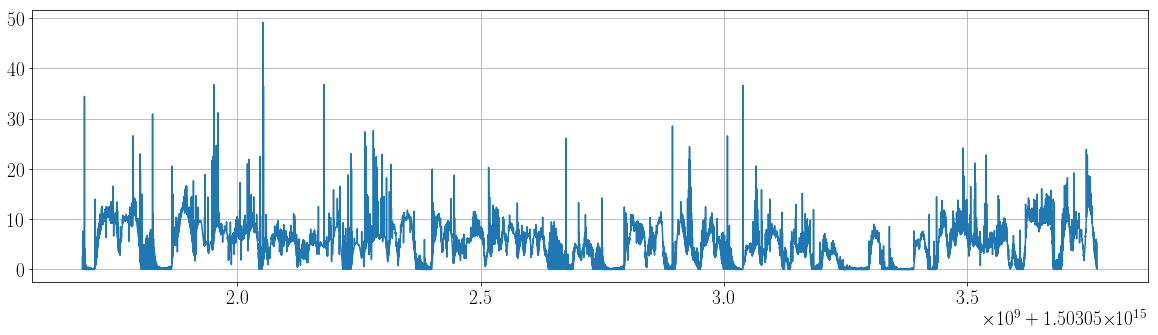

In [80]:
# get INS speeds
assert len(INS_se3s) == len(INS_timestamps)
INS_speeds = []
INS_TIMESTAMPS = []
deltatime_arr = []
for i in range(1,len(INS_timestamps)):
# for i in range(1000,2000):
    # work out speed
    delta_time = (INS_timestamps[i] - INS_timestamps[i - 1]) / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = INS_se3s[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    INS_speeds.append(speed)
    INS_TIMESTAMPS.append(INS_timestamps[i])
plt.figure(figsize=(20,5))
plt.plot(INS_TIMESTAMPS,INS_speeds);

Text(0,0.5,'Velocity (m/s)')

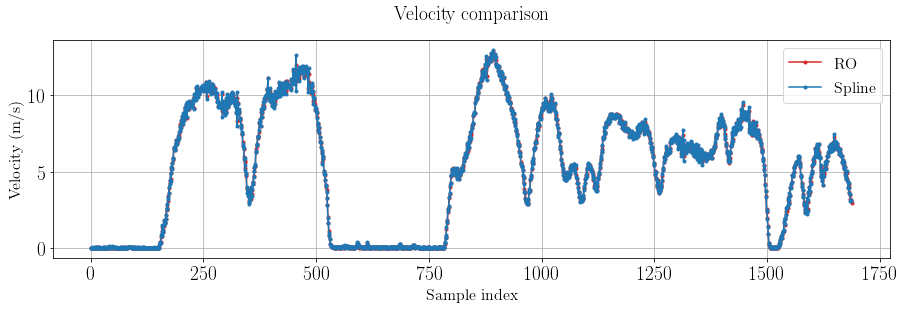

In [131]:
# get speeds
assert len(RO_se3s) == len(RO_timestamps)
RO_speeds = []
RO_TIMESTAMPS = []
deltatime_arr = []
for i in range(1,len(RO_timestamps)):
    # work out speed
    delta_time = (RO_timestamps[i] - RO_timestamps[i - 1]) / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = RO_se3s[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    RO_speeds.append(speed)
    RO_TIMESTAMPS.append(RO_timestamps[i])
    
# Technically there's a more principled way to determine speed from the control points using spline fusion
# This method is naive differentiation, but the speeds will change slightly depending 
# on the resolution of the estimated points
assert len(spline_se3s) == len(spline_timestamps)
spline_speeds = []
spline_TIMESTAMPS = []
deltatime_arr = []
for i in range(1,len(spline_timestamps)):
    # work out speed
    delta_time = (spline_timestamps[i] - spline_timestamps[i - 1]) / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = spline_se3s[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    spline_speeds.append(speed)
    spline_TIMESTAMPS.append(spline_timestamps[i])

plt.figure(figsize=(15,4)) # was 20,17
plt.plot(RO_speeds,'.-',color=colour_ro);
plt.plot(spline_speeds,'.-',color=colour_spline);
plt.legend(('RO','Spline'));
plt.title('Velocity comparison')
plt.xlabel('Sample index')
plt.ylabel('Velocity (m/s)')
# plt.plot(RO_speeds[2:100],'-*');
# plt.plot(spline_speeds[0:100]);
# plt.plot(spline_speeds[2:100]);

In [117]:
INS_seconds = [(timestamp - INS_TIMESTAMPS[0]) / settings.TIMESTAMP_CONVERSION for timestamp in INS_TIMESTAMPS]
RO_seconds = [(timestamp - RO_TIMESTAMPS[0]) / settings.TIMESTAMP_CONVERSION for timestamp in RO_TIMESTAMPS]
spline_seconds = [(timestamp - spline_TIMESTAMPS[0]) / settings.TIMESTAMP_CONVERSION for timestamp in spline_TIMESTAMPS]

time_offset = (INS_TIMESTAMPS[0] - RO_timestamps[0])/settings.TIMESTAMP_CONVERSION

In [116]:
print(INS_timestamps[0])
print(INS_TIMESTAMPS[0])

print(RO_timestamps[0])
print(RO_TIMESTAMPS[0])
print(RO_TIMESTAMPS[0] - RO_timestamps[0])
print(INS_timestamps[0] - RO_timestamps[0])
print((INS_TIMESTAMPS[0] - RO_timestamps[0])/settings.TIMESTAMP_CONVERSION)

1503051681337404
1503051681357404
1503051668408579
1503051668907899
499320
12928825
12.948825


Text(0,0.5,'Velocity (m/s)')

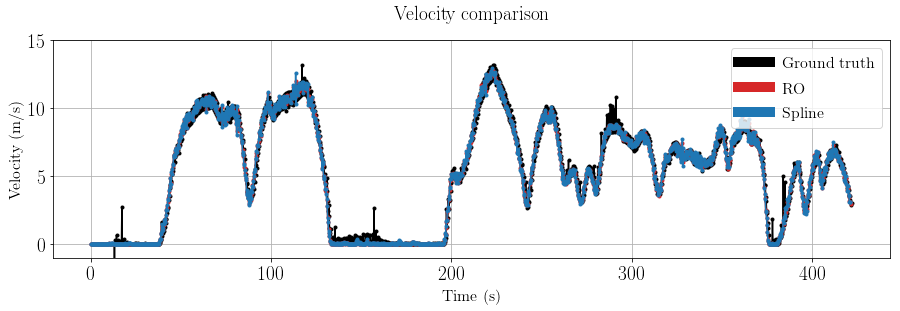

In [125]:
# Do interpolation (accumulatation for now)
interp_INS_speed = []
interp_INS_seconds = []
distance = 0
temp_speed = 0
j = 0
for i in range(len(RO_timestamps)):
    while(INS_timestamps[j] < RO_timestamps[i]):
        distance += INS_speeds[j]*(INS_timestamps[j]-INS_timestamps[j-1])
        j+=1
    temp_speed = distance/(RO_timestamps[i]-RO_timestamps[i-1])
    interp_INS_speed.append(temp_speed)
    interp_INS_seconds.append(((INS_TIMESTAMPS[j] - INS_TIMESTAMPS[0]) / settings.TIMESTAMP_CONVERSION) + time_offset)
    distance = 0
    
plt.figure(figsize=(15,4))
plt.plot(interp_INS_seconds,interp_INS_speed,'.-',color=colour_ins)
plt.plot(RO_seconds,RO_speeds,'.-',color=colour_ro);
plt.plot(spline_seconds,spline_speeds,'.-',color=colour_spline);

plt.ylim(-1,15)
# plt.xlim(0,100)
line1, = plt.plot([],[],color=colour_ins,label='Ground truth',linewidth=10.0)
line2, = plt.plot([],[],color=colour_ro,label='RO',linewidth=10.0)
line3, = plt.plot([],[],color=colour_spline,label='Spline',linewidth=10.0)
plt.legend(handles=[line1,line2,line3],loc='best')
plt.title('Velocity comparison')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')

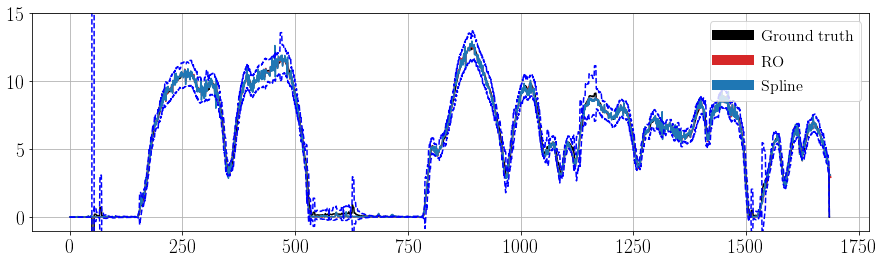

In [149]:
window_size = 5
std_devs = []
means = []
n_sigmas = 2
x_start = 0 #1000
x_end = len(interp_INS_speed) #1500

for i in range(window_size//2,len(interp_INS_speed)-window_size//2):
    window_contents = interp_INS_speed[i-window_size//2:i+window_size//2]
    std_devs.append(std(window_contents))
    means.append(mean(window_contents))
    
means = np.array(means)
means[-window_size//2:] = 0
means = np.roll(means,window_size//2)

std_devs = np.array(std_devs)
std_devs[-window_size//2:] = 0
std_devs = np.roll(std_devs,window_size//2)

plt.figure(figsize=(15,4))
plt.plot(means[x_start:x_end],color=colour_ins)
plt.plot(RO_speeds[x_start:x_end],'-',color=colour_ro);
plt.plot(spline_speeds[x_start:x_end],'-',color=colour_spline);
plt.plot(means[x_start:x_end]+n_sigmas*std_devs[x_start:x_end],'b--')
plt.plot(means[x_start:x_end]-n_sigmas*std_devs[x_start:x_end],'b--')

plt.ylim(-1,15)
# plt.xlim(100,300)

line1, = plt.plot([],[],color=colour_ins,label='Ground truth',linewidth=10.0)
line2, = plt.plot([],[],color=colour_ro,label='RO',linewidth=10.0)
line3, = plt.plot([],[],color=colour_spline,label='Spline',linewidth=10.0)
plt.legend(handles=[line1,line2,line3],loc='best')

# plt.plot(means[2000:2500])
# plt.plot(RO_speeds[2005:2505])
# plt.plot(means[2000:2500]+n_sigmas*std_devs[2000:2500],'b--')
# plt.plot(means[2000:2500]-n_sigmas*std_devs[2000:2500],'b--')

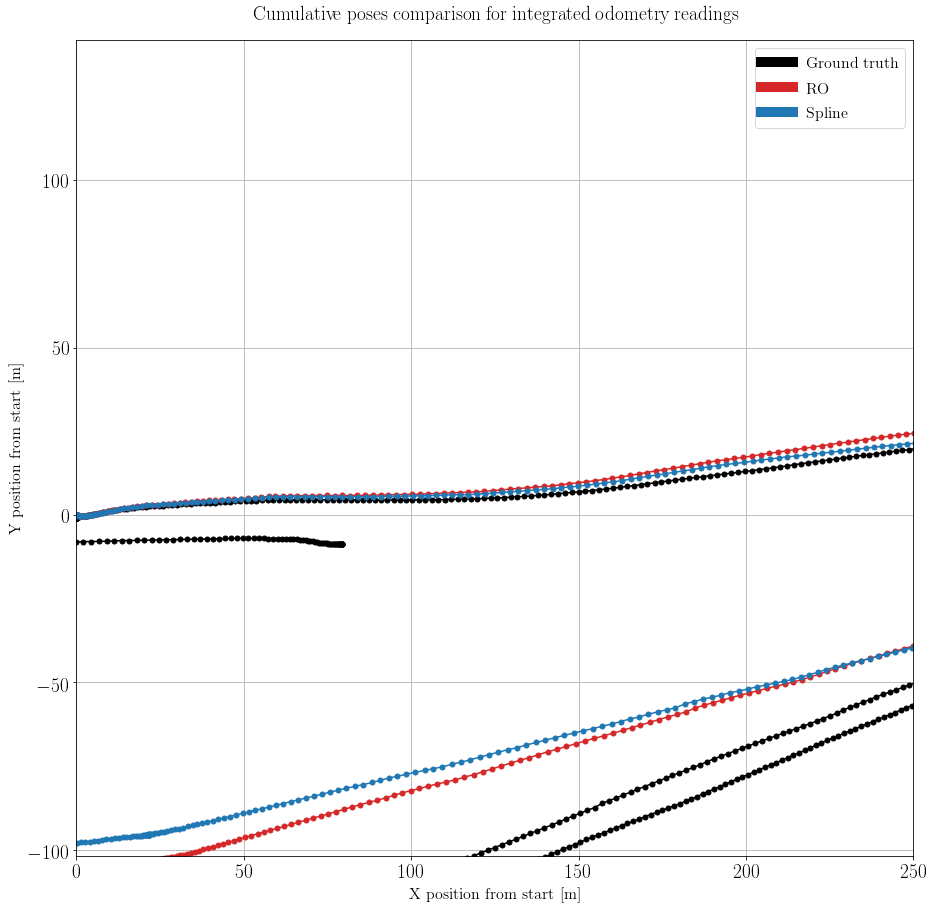

In [19]:
plt.figure(figsize=(15,15))
plt.plot(x_INS_lite,y_INS_lite,'.-',color=colour_ins,markersize=10);
plt.plot(x_RO,y_RO,'.-',color=colour_ro,markersize=10);
plt.plot(x_spline,y_spline,'.-',color=colour_spline,markersize=10);
plt.axis('equal');
plt.title('Cumulative poses comparison for integrated odometry readings');
plt.xlabel('X position from start [m]');
plt.ylabel('Y position from start [m]');
line1, = plt.plot([],[],color=colour_ins,label='Ground truth',linewidth=10.0)
line2, = plt.plot([],[],color=colour_ro,label='RO',linewidth=10.0)
line3, = plt.plot([],[],color=colour_spline,label='Spline',linewidth=10.0)
plt.xlim(0, 250)
plt.ylim(0,40)
plt.legend(handles=[line1,line2,line3],loc='best')

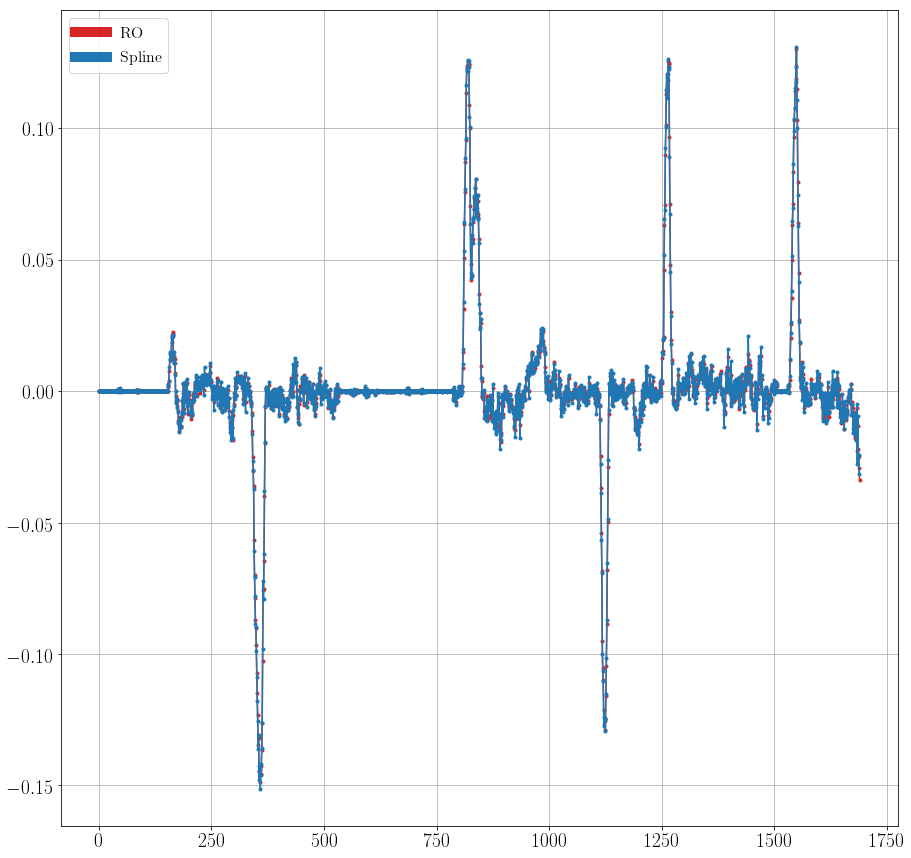

In [10]:
RO_thetas = [np.arctan2(x[1, 0], x[0, 0]) for x in RO_se3s]
spline_thetas = [np.arctan2(x[1, 0], x[0, 0]) for x in spline_se3s]
plt.figure(figsize=(15,15)) # was 15,15

plt.plot(RO_thetas,'.-',color=colour_ro)
plt.plot(spline_thetas,'.-',color=colour_spline)
# plt.title('Cumulative poses comparison for integrated odometry readings');
# plt.xlabel('X position from start [m]');
# plt.ylabel('Y position from start [m]');
# line1, = plt.plot([],[],color=color_ins,label='Ground truth',linewidth=10.0)
line2, = plt.plot([],[],color=colour_ro,label='RO',linewidth=10.0)
line4, = plt.plot([],[],color=colour_spline,label='Spline',linewidth=10.0)
# plt.xlim(100, 120)
# plt.ylim(0.025,0.05)
plt.legend(handles=[line2,line4],loc='best')

In [11]:
print(np.mean(spline_speeds))
print(np.mean(RO_speeds))

ddd = np.diff(spline_thetas)
print(np.mean(ddd))

ddd = np.diff(RO_thetas)
print(np.mean(ddd))

5.353466026464464
5.348288833359753
-1.8583835596555617e-05
-2.009921101222038e-05


In [12]:
size(spline_TIMESTAMPS)

1688

In [13]:
size(RO_timestamps)

1690

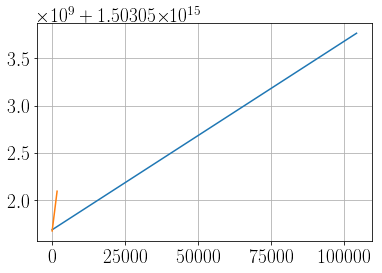

In [154]:
plt.plot(INS_TIMESTAMPS)
plt.plot(RO_TIMESTAMPS)
# plt.plot(INS_timestamps)

In [15]:
INS_TIMESTAMPS[0]

1503051701337901

In [16]:
INS_timestamps[0]

1503051681337404

In [ ]:
RO_TIMESTAMPS[0]